## LCA Analysis Playbook

In [5]:
%matplotlib inline

In [6]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt, mpld3
import requests as re
from bs4 import BeautifulSoup
import csv
from collections import defaultdict, Counter

In [7]:
DATA_FOLDER = './data'
F15 = 'LCA_2015.csv'
PERM_F15 = 'PERM_2015.csv'
CERTIFIED_STR = 'CERTIFIED'
H1B_STR = 'H-1B'
H1B1_STR_Chile = 'H-1B1 Chile'
H1B1_STR_Singapore = 'H-1B1 Singapore'
E3_STR = 'E-3 Australian'

In [8]:
company_count = defaultdict(int)
company_perm_count = defaultdict(int)

In [9]:
company_prevailing_wages = defaultdict(lambda: np.ndarray(0))
company_wages = defaultdict(lambda: np.ndarray(0))
h1b1_chile_wages = np.ndarray(0)
h1b1_singapore_wages = np.ndarray(0)
e3_australia_wages = np.ndarray(0)

In [10]:
state_counts = defaultdict(int)

In [11]:
top_public_firms = [
    'NETFLIX, INC.',
    'GOOGLE INC.',
    'FACEBOOK, INC.',
    'APPLE INC.',
    'MICROSOFT CORPORATION',
    'TWITTER, INC.',
    'LINKEDIN CORPORATION',
    'VMWARE, INC.',
    'AMAZON CORPORATE LLC',
    'PAYPAL, INC.'
]

outsourcing_firms = [
    'INFOSYS LIMITED',
    'TATA CONSULTANCY SERVICES LIMITED',
    'WIPRO LIMITED',
    'ACCENTURE LLP',
    'IBM INDIA PRIVATE LIMITED',
    'HCL AMERICA, INC.',
    'IGATE TECHNOLOGIES INC.',
    'LARSEN & TOUBRO INFOTECH LIMITED',
    'TECH MAHINDRA (AMERICAS),INC.',
    'L&T TECHNOLOGY SERVICES LIMITED',
    'COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION',
    'LARSEN & TOUBRO TECHNOLOGY SERVICES LTD',
    'L&T TECHNOLOGY SERVICES, LTD.'
]

unicorns = [
    'UBER TECHNOLOGIES, INC.',
    'DROPBOX, INC.',
    'PINTEREST, INC.',
    'AIRBNB, INC.',
    'PALANTIR TECHNOLOGIES INC.',
    'SNAPCHAT, INC.',
    'STRIPE, INC.',
    'SLACK TECHNOLOGIES, INC.',
    'GITHUB, INC.',
    'APPDYNAMICS, INC.'
]

# Map company names from LCA file to PERM file for year 2015
lca_to_perm_correction = {
    'NETFLIX, INC.': 'NETFLIX',
    'UBER TECHNOLOGIES, INC.': 'UBER TECHNOLOGIES INC.',
    'PALANTIR TECHNOLOGIES INC.': 'PALANTIR TECHNOLOGIES',
    'APPDYNAMICS, INC.': 'APPDYNAMICS',
    'SALESFORCE.COM, INC.': 'SALESFORCE.COM',
    'INFOSYS LIMITED': 'INFOSYS LTD.',
    'HCL AMERICA, INC.' : 'HCL AMERICA INC.',
    'IGATE TECHNOLOGIES INC.': 'IGATE TECHNOLOGIES, INC.',
    'COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION': 'COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION',
    'TECH MAHINDRA (AMERICAS),INC.': 'TECH MAHINDRA (AMERICAS) INC.'
}

In [12]:
def isFloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def process_wage(wage_str):
    wage_range = [float(s) for s in wage_str.split() if isFloat(s)]
    return wage_range[0]

def store_company_data(employer, prevailing_wage, wage, state):
    company_count[employer] += 1
    prevailing_wage_int = process_wage(prevailing_wage)
    wage_int = process_wage(wage)
    company_wages[employer] = np.append(company_wages[employer], wage_int)
    company_prevailing_wages[employer] = np.append(company_prevailing_wages[employer], prevailing_wage_int)
    # Later analysis
    if employer in outsourcing_firms:
        state_counts[state] += 1

In [13]:
with open(DATA_FOLDER + '/' + F15) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    total_count, certified_count = 0, 0
    for row in csv_reader:
        if row['CASE_STATUS'] == CERTIFIED_STR \
            and row['WAGE_UNIT_OF_PAY'] == 'Year'\
            and row['PW_UNIT_OF_PAY'] == 'Year':
                if row['VISA_CLASS'] == H1B_STR:
                    store_company_data(row['EMPLOYER_NAME'],
                                       row['PREVAILING_WAGE'],
                                       row['WAGE_RATE_OF_PAY'],
                                       row['WORKSITE_STATE'])
                elif row['VISA_CLASS'] == H1B1_STR_Chile:
                    h1b1_chile_wages = np.append(h1b1_chile_wages, process_wage(row['WAGE_RATE_OF_PAY']))
                elif row['VISA_CLASS'] == H1B1_STR_Singapore:
                    h1b1_singapore_wages = np.append(h1b1_singapore_wages, process_wage(row['WAGE_RATE_OF_PAY']))
                elif row['VISA_CLASS'] == E3_STR:
                    e3_australia_wages = np.append(e3_australia_wages, process_wage(row['WAGE_RATE_OF_PAY']))
                certified_count += 1
        total_count += 1
    print certified_count, total_count, total_count - certified_count, (certified_count) / (total_count * 1.)

513044 618804 105760 0.829089663286


In [14]:
def print_md_table_median(firms):
    print('{:50s} {:12s} {:10s} {:10s}'.format('Company ', '| Count ', '| Median Wage ', '| Mean Wage'))
    print('---------------------------------------------------|------------|--------------|------------')
    total = 0
    for firm in firms:
        print('{:50s} | {:10.0f} | {:12.3f} | {:12.3f}'.format(firm, 
                                                  company_count[firm], 
                                                  np.median(company_wages[firm]),
                                                  np.mean(company_wages[firm])
                                                  ))
        total += company_count[firm]
    print
    print('Total count : {}'.format(total))

In [15]:
print_md_table_median(top_public_firms)

Company                                            | Count      | Median Wage  | Mean Wage
---------------------------------------------------|------------|--------------|------------
NETFLIX, INC.                                      |        140 |   240100.000 |   236405.540
GOOGLE INC.                                        |       2358 |   127500.000 |   131028.201
FACEBOOK, INC.                                     |        837 |   140000.000 |   141033.289
APPLE INC.                                         |       1341 |   124700.000 |   123693.436
MICROSOFT CORPORATION                              |       3724 |   121500.000 |   123776.806
TWITTER, INC.                                      |        266 |   138000.000 |   140100.500
LINKEDIN CORPORATION                               |        431 |   109762.000 |   112246.067
VMWARE, INC.                                       |        433 |   122400.000 |   126151.288
AMAZON CORPORATE LLC                               |       1702 

In [16]:
print_md_table_median(unicorns)

Company                                            | Count      | Median Wage  | Mean Wage
---------------------------------------------------|------------|--------------|------------
UBER TECHNOLOGIES, INC.                            |        294 |   115000.000 |   115327.677
DROPBOX, INC.                                      |         69 |   135000.000 |   131504.116
PINTEREST, INC.                                    |         32 |   111500.000 |   109880.812
AIRBNB, INC.                                       |         88 |   150000.000 |   147924.932
PALANTIR TECHNOLOGIES INC.                         |         90 |   112000.000 |   115165.442
SNAPCHAT, INC.                                     |         30 |    99798.000 |    94349.667
STRIPE, INC.                                       |         19 |    94162.000 |    95319.737
SLACK TECHNOLOGIES, INC.                           |          2 |   121000.000 |   121000.000
GITHUB, INC.                                       |          5 

In [17]:
print_md_table_median(outsourcing_firms)

Company                                            | Count      | Median Wage  | Mean Wage
---------------------------------------------------|------------|--------------|------------
INFOSYS LIMITED                                    |      33204 |    74310.000 |    79175.577
TATA CONSULTANCY SERVICES LIMITED                  |      16435 |    68000.000 |    69658.413
WIPRO LIMITED                                      |      10499 |    68432.000 |    70240.084
ACCENTURE LLP                                      |       9467 |    75299.000 |    77862.866
IBM INDIA PRIVATE LIMITED                          |       9027 |    73650.000 |    74537.763
HCL AMERICA, INC.                                  |       6086 |    70762.000 |    71137.241
IGATE TECHNOLOGIES INC.                            |       4395 |    67400.000 |    68743.353
LARSEN & TOUBRO INFOTECH LIMITED                   |       3446 |    70950.000 |    73320.329
TECH MAHINDRA (AMERICAS),INC.                      |       3295 

In [18]:
def get_all_wages(firms):
    wages = np.ndarray(0)
    total = 0
    for firm in firms:
        wages = np.concatenate((wages, company_wages[firm]))
        total += len(company_wages[firm])
    print "{} rows processed".format(total)
    return wages
outsourcing_firms_wages = get_all_wages(outsourcing_firms)

100990 rows processed


In [19]:
public_firm_wages = get_all_wages(top_public_firms)

11822 rows processed


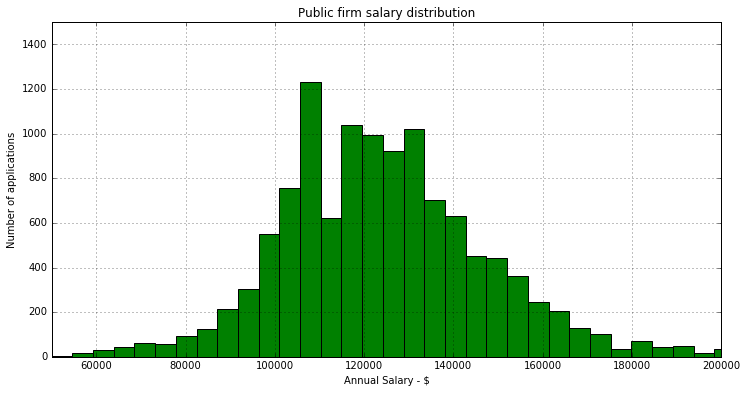

In [20]:
num_bins = 100
plt.figure(figsize=(12,6)) 
plt.axis([50000, 200000, 0, 1500])
plt.title('Public firm salary distribution')
plt.xlabel('Annual Salary - $')
plt.ylabel('Number of applications')
plt.hist(public_firm_wages, num_bins, color='green', alpha=1)[2]
plt.grid(True)
plt.show()

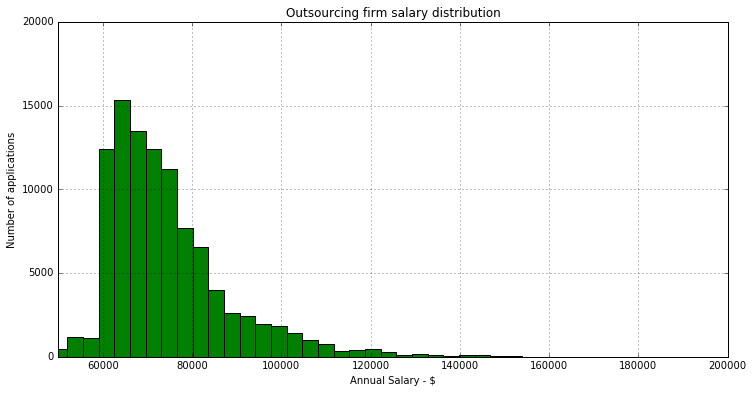

In [21]:
num_bins = 100
plt.figure(figsize=(12,6)) 
plt.axis([50000, 200000, 0, 20000])
plt.title('Outsourcing firm salary distribution')
plt.xlabel('Annual Salary - $')
plt.ylabel('Number of applications')
plt.hist(outsourcing_firms_wages, num_bins, color='green', alpha=1)[2]
plt.grid(True)
plt.show()

714 rows processed


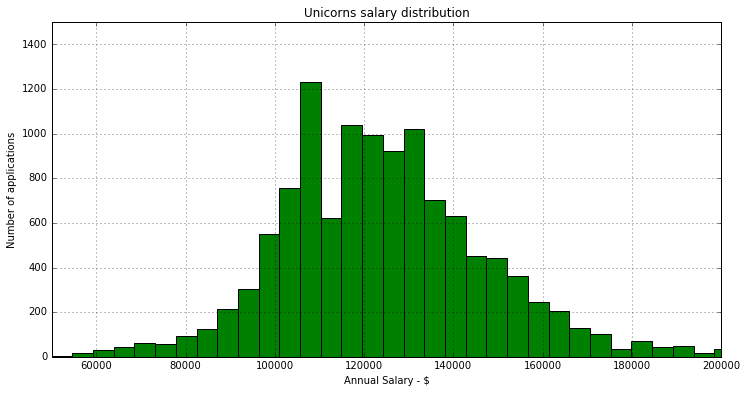

In [22]:
unicorn_wages = get_all_wages(unicorns)
num_bins = 100
plt.figure(figsize=(12, 6)) 
plt.axis([50000, 200000, 0, 1500])
plt.title('Unicorns salary distribution')
plt.xlabel('Annual Salary - $')
plt.ylabel('Number of applications')
plt.hist(public_firm_wages, num_bins, color='green', alpha=1)[2]
plt.grid(True)
plt.show()

In [23]:
with open(DATA_FOLDER + '/' + PERM_F15) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    total_count = 0
    for row in csv_reader:
        company_perm_count[row['EMPLOYER_NAME']] += 1
        total_count += 1
    print "Total records processed : {}".format(total_count)

Total records processed : 89151


In [24]:
def generate_double_bar_chart(firms, title):
    N = len(firms)
    index = np.array(range(N))
    bar_width = 0.35
    
    h1b_applications, perm_applications = [], []
    for firm in firms:
        if firm == 'GOOGLE INC.':
            #Google files as GOOGLE, INC. and GOOGLE INC. Adding both counts
            h1b_applications.append(company_count[firm] + company_count['GOOGLE, INC.'])
        else:
            h1b_applications.append(company_count[firm])
        perm_firm_str = firm
        if firm in lca_to_perm_correction.keys():
            perm_firm_str = lca_to_perm_correction[firm]
        perm_applications.append(company_perm_count[perm_firm_str])
    h1_applications = tuple(h1b_applications)
    perm_applications = tuple(perm_applications)
    
    plt.figure(figsize=(18,10))
    rects1 = plt.bar(index, h1b_applications, bar_width,
                 color='r',
                 label='H1B applications')

    rects2 = plt.bar(index + bar_width, perm_applications, bar_width,
                 color='b',
                 label='PERM applications')
    
    labels = [x[:10] for x in firms]
    
    plt.xticks(index + bar_width, labels)
    plt.xlabel('Firm')
    plt.ylabel('Number')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

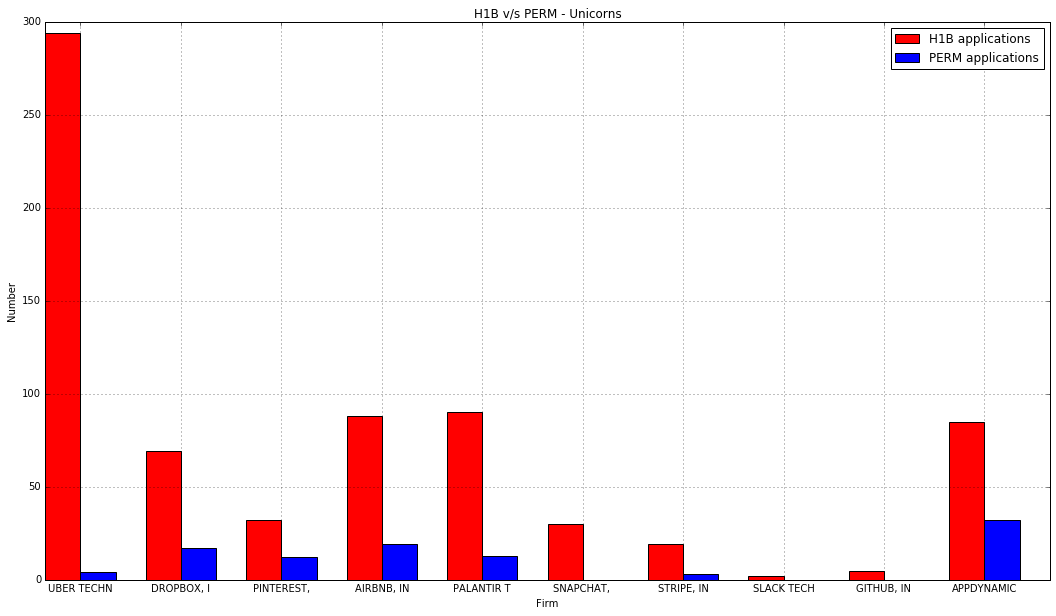

In [25]:
generate_double_bar_chart(unicorns, 'H1B v/s PERM - Unicorns')

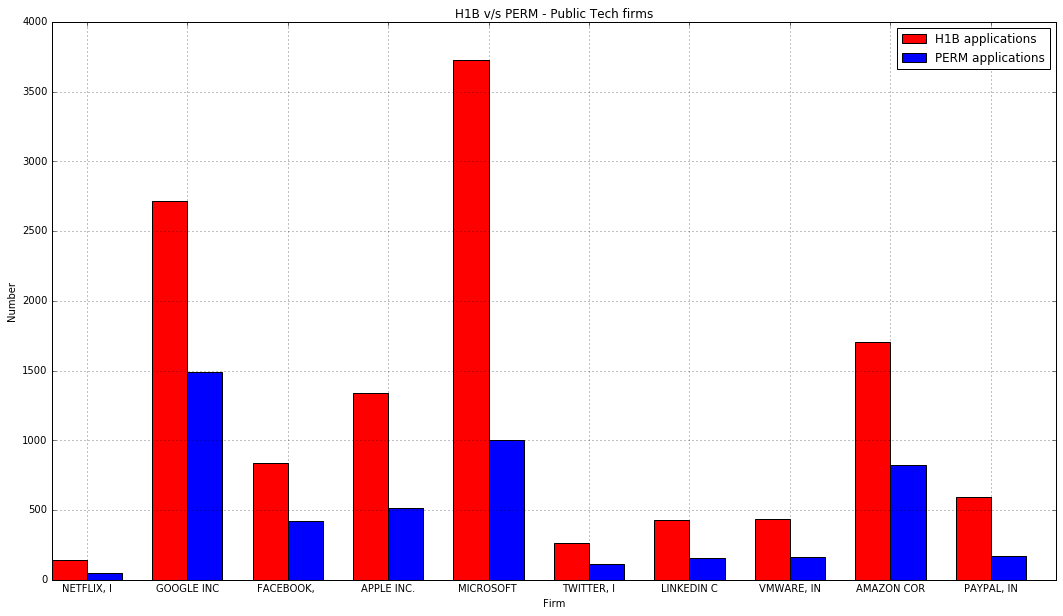

In [26]:
generate_double_bar_chart(top_public_firms, 'H1B v/s PERM - Public Tech firms')

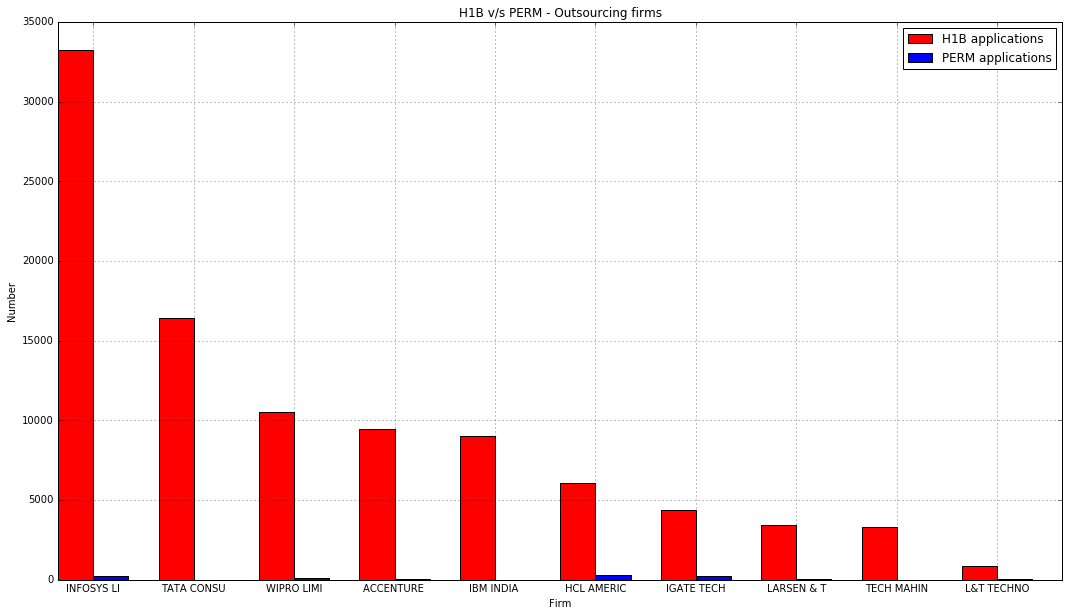

In [27]:
generate_double_bar_chart(outsourcing_firms[:10], 'H1B v/s PERM - Outsourcing firms')

In [28]:
print company_perm_count['TATA CONSULTANCY SERVICES LIMITED']
# :O

4


In [29]:
print sorted(state_counts.iteritems(),key=lambda (k,v): v,reverse=True)[:10]

[('CA', 14848), ('TX', 10070), ('NJ', 8552), ('IL', 6708), ('NC', 4741), ('NY', 4430), ('WA', 4228), ('GA', 3914), ('CT', 3865), ('OH', 3753)]


In [30]:
print ('{:30s} | {:20s} | {:20s} | {:10s}'.format('Visa program', 'No. applications', 
                                                    'Median wage', 'Average wage'))
print('-------------------------------|----------------------|----------------------|-------------------------')
format_str = '{:30s} | {:20.0f} | {:20.2f} | {:20.2f}'
print (format_str.format('H1-B1 Chile', len(h1b1_chile_wages), 
                                                    np.median(h1b1_chile_wages), np.mean(h1b1_chile_wages)))
print (format_str.format('H1-B1 Singapore', len(h1b1_singapore_wages), 
                                                    np.median(h1b1_singapore_wages), np.mean(h1b1_singapore_wages)))
print (format_str.format('E-3 Australian', len(e3_australia_wages), 
                                                    np.median(e3_australia_wages), np.mean(e3_australia_wages)))

Visa program                   | No. applications     | Median wage          | Average wage
-------------------------------|----------------------|----------------------|-------------------------
H1-B1 Chile                    |                  494 |             80000.00 |             90921.47
H1-B1 Singapore                |                  842 |             84755.00 |             92727.06
E-3 Australian                 |                 8148 |             98000.00 |            111366.55


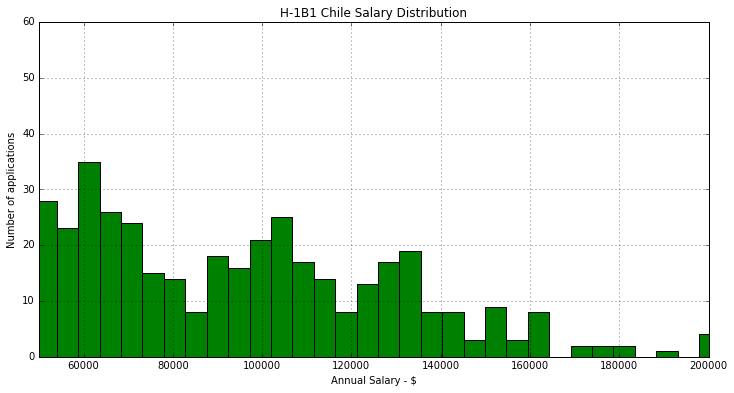

In [31]:
num_bins = 100
plt.figure(figsize=(12, 6)) 
plt.axis([50000, 200000, 0, 60])
plt.title('H-1B1 Chile Salary Distribution')
plt.xlabel('Annual Salary - $')
plt.ylabel('Number of applications')
plt.hist(h1b1_chile_wages, num_bins, color='g', alpha=1)[2]
plt.grid(True)
plt.show()

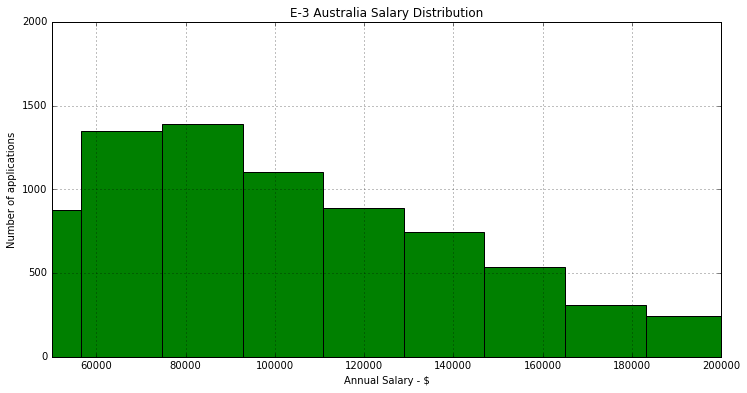

In [32]:
num_bins = 100
plt.figure(figsize=(12, 6)) 
plt.axis([50000, 200000, 0, 2000])
plt.title('E-3 Australia Salary Distribution')
plt.xlabel('Annual Salary - $')
plt.ylabel('Number of applications')
plt.hist(e3_australia_wages, num_bins, color='g', alpha=1)[2]
plt.grid(True)
plt.show()